In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 1. Cargamos Dataset

In [2]:
data = pd.read_csv('train.csv')

print(str(data.shape) + '\n')

data.head()

(1460, 81)



,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Eliminamos columna de id 

In [3]:
data.drop('Id', axis=1, inplace=True)

print(str(data.shape))

(1460, 80)


### 2. Análisis de Datos para toma de decisiones en FE Pipeline

##### 2.1 Análisis del Taget


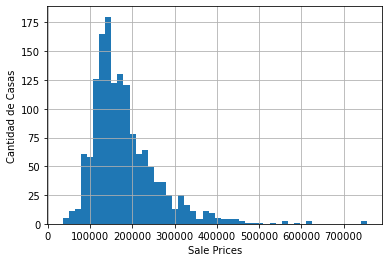

In [4]:
data['SalePrice'].hist(bins=50, density=False)
plt.xlabel("Sale Prices")
plt.ylabel("Cantidad de Casas")
plt.show()

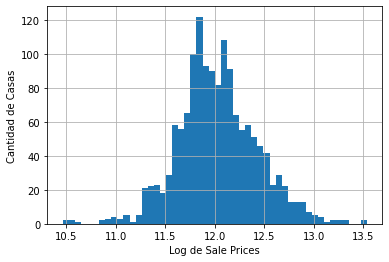

In [5]:
#transformación de target con log.
np.log(data['SalePrice']).hist(bins=50, density=False)
plt.xlabel("Log de Sale Prices")
plt.ylabel("Cantidad de Casas")
plt.show()

A partir de la transformación logaritmica notamos una mejora en la forma de la distribución, por tanto aplicaremos esta transformación al entrenamiento del modelo.

#### 2.2 Verificamos tipos de variables en X

In [6]:
data.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 80, dtype: object

In [11]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']

#Agregamos el caso especial de MSSubClass ya que por definición, esta variable es categórica 
cat_vars = cat_vars + ['MSSubClass'] 

In [12]:
#cantidad de varaibles categóricas
len(cat_vars)

45

In [13]:
#Forzamos a todas las variables como categóticas
data[cat_vars] = data[cat_vars].astype('O')

In [14]:
#variables numéricas
num_vars = [var for var in data.columns if(var not in cat_vars and var != 'SalesPrice')]

In [15]:
len(num_vars)

36

#### 2.3 Análisis de Valores Faltantes

In [16]:
var_with_na = [var for var in data.columns if(data[var].isnull().sum() > 0)]
len(var_with_na)

19

In [18]:
#proporcion de NAs en cada variable
data[var_with_na].isnull().mean().sort_values(ascending=False)

PoolQC          0.995205
MiscFeature     0.963014
Alley           0.937671
Fence           0.807534
FireplaceQu     0.472603
LotFrontage     0.177397
GarageYrBlt     0.055479
GarageType      0.055479
GarageFinish    0.055479
GarageQual      0.055479
GarageCond      0.055479
BsmtFinType2    0.026027
BsmtExposure    0.026027
BsmtFinType1    0.025342
BsmtCond        0.025342
BsmtQual        0.025342
MasVnrArea      0.005479
MasVnrType      0.005479
Electrical      0.000685
dtype: float64

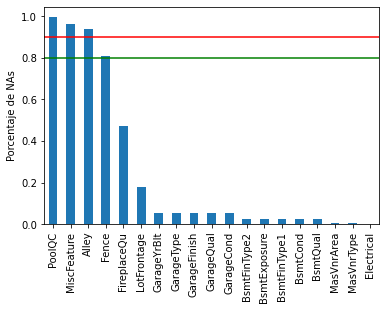

In [19]:
#graficamos porcentajes de NAs.
data[var_with_na].isnull().mean().sort_values(ascending=False).plot.bar()
plt.ylabel("Porcentaje de NAs")
plt.axhline(y=0.9, color="r")
plt.axhline(y=0.8, color="g")

In [20]:
#variables categóricas con NAs.
cat_na = [var for var in cat_vars if var in var_with_na]
cat_na

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [21]:
#variables numéricas con NAs.
num_na = [var for var in num_vars if var in var_with_na]
num_na

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [22]:
print("Cantidad de variables numéricas con NAs. {}".format(len(num_na)))
print("Cantidad de variables categóticas con NAs. {}".format(len(cat_na)))

Cantidad de variables numéricas con NAs. 3
Cantidad de variables categóticas con NAs. 16


#### 2.3.1 Verificación del impacto del NA contra el Target (SalePrice)

In [23]:
def na_impact_over_target(df, Xvar, Yvar):
    df = data.copy()
    df[Xvar] = np.where(df[Xvar].isnull(), 1, 0)
    temp = df.groupby(Xvar)[Yvar].agg(['mean', 'std'])
    temp.plot(kind="barh", y="mean", xerr="std", legend=False, title=Yvar)
    plt.show()

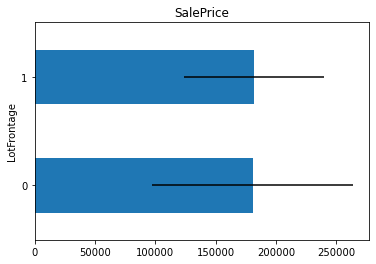

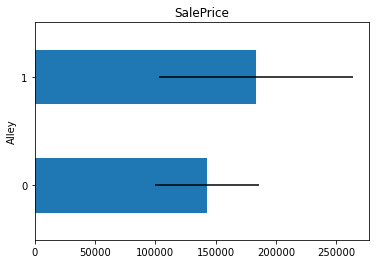

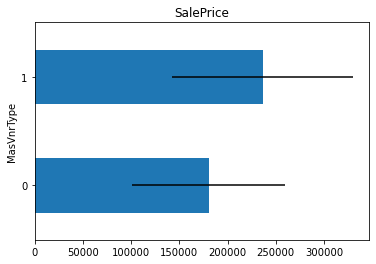

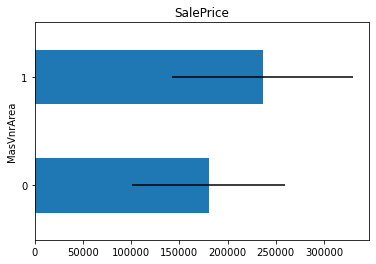

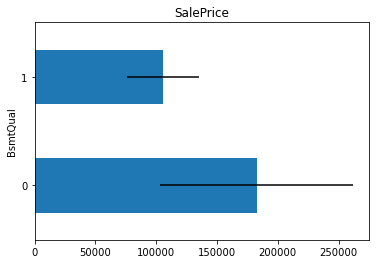

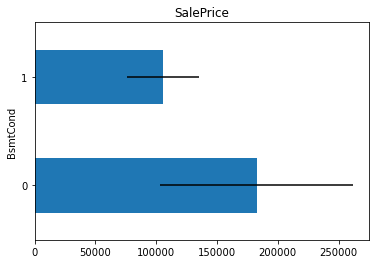

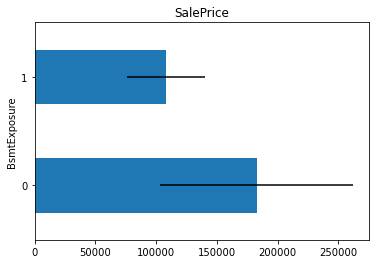

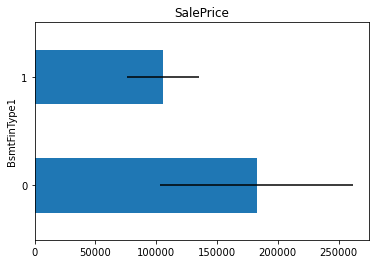

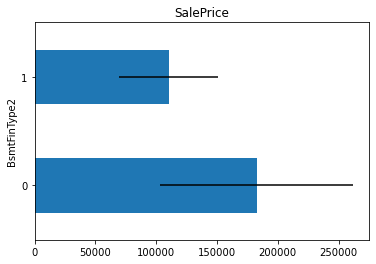

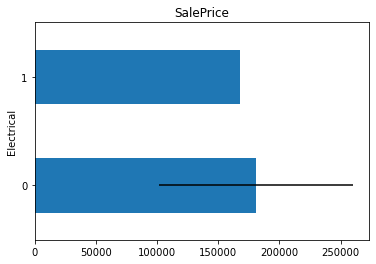

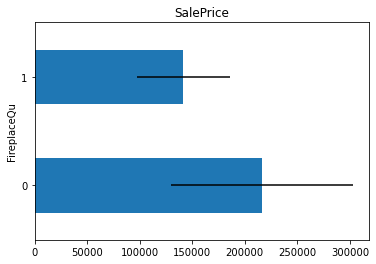

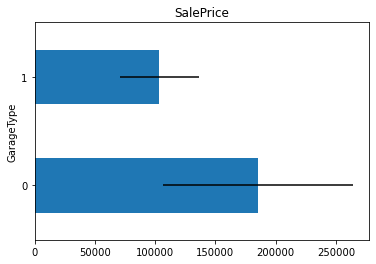

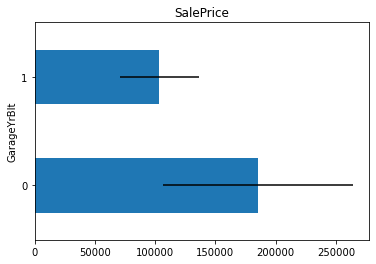

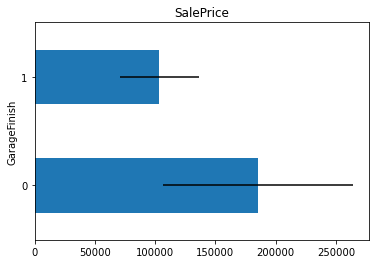

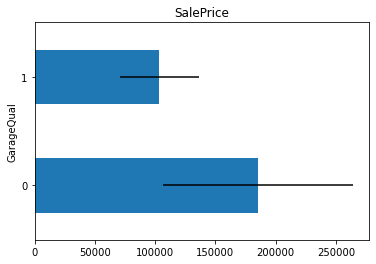

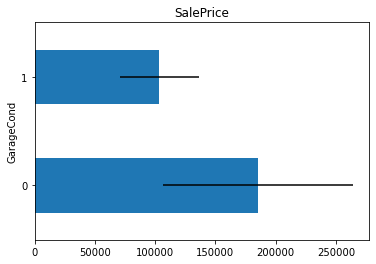

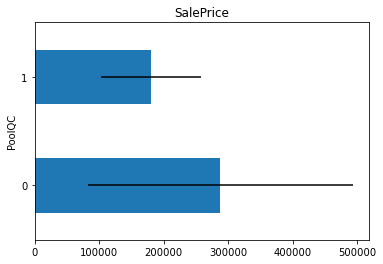

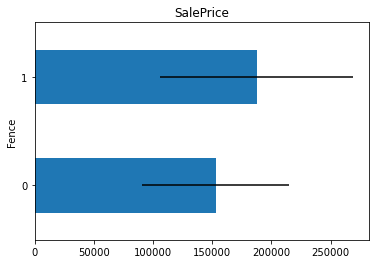

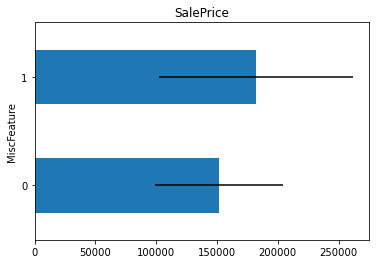

In [24]:
for var in var_with_na:
    na_impact_over_target(data, var, 'SalePrice')

<AxesSubplot:ylabel='PoolQC'>

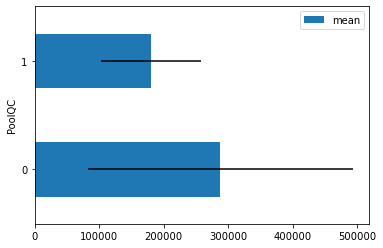

#### 2.4 Análisis de Variables Temporales

In [25]:
year_vars = [var for var in num_vars if (('Yr' in var) or ('Year' in var))]
year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [26]:
for var in year_vars:
    print(var, data[var].unique())
    print('\n')

YearBuilt [2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972
 1921 1945 1982 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985
 1979 1885 1919 1990 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926
 1940 1941 1987 1986 2008 1908 1892 1916 1932 1918 1912 1947 1925 1900
 1980 1989 1992 1949 1880 1928 1978 1922 1996 2010 1946 1913 1937 1942
 1938 1974 1893 1914 1906 1890 1898 1904 1882 1875 1911 1917 1872 1905]


YearRemodAdd [2003 1976 2002 1970 2000 1995 2005 1973 1950 1965 2006 1962 2007 1960
 2001 1967 2004 2008 1997 1959 1990 1955 1983 1980 1966 1963 1987 1964
 1972 1996 1998 1989 1953 1956 1968 1981 1992 2009 1982 1961 1993 1999
 1985 1979 1977 1969 1958 1991 1971 1952 1975 2010 1984 1986 1994 1988
 1954 1957 1951 1978 1974]


GarageYrBlt [2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2

<AxesSubplot:xlabel='YearBuilt'>

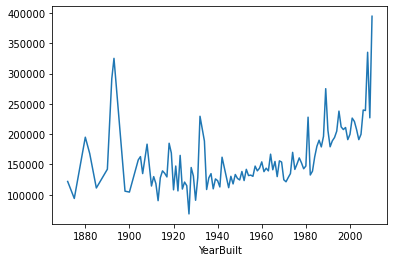

In [27]:
data.groupby('YearBuilt')['SalePrice'].median().plot()

In [28]:
def plot_target_vrs_timeVar(df, Xvar, Yvar):
    df = df.copy()
    df.groupby(Xvar)[Yvar].median().plot()
    plt.show()

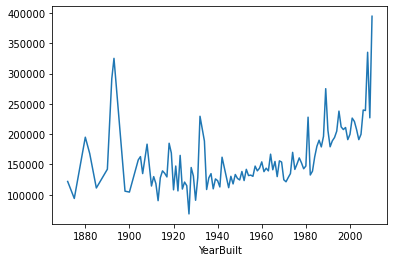

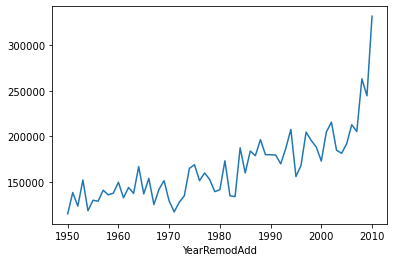

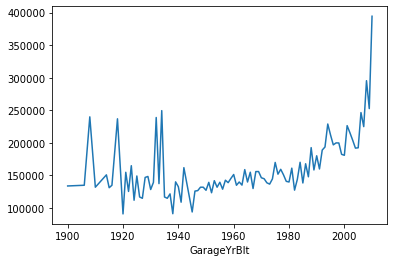

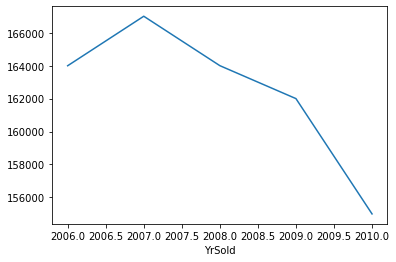

In [30]:
#varificamos del año sobre el precio.
for var in year_vars:
    plot_target_vrs_timeVar(data, var, 'SalePrice')

In [32]:
#Analizamos el momento en el que se vendió la casa contra los demás eventos.
def analyse_yearSold_vrs_timeEvents(df, var, varRef):
    df = df.copy()
    df[var] = df[varRef] - df[var]
    df.groupby(varRef)[var].median().plot()
    plt.ylabel('Time from ' + var)
    plt.show()

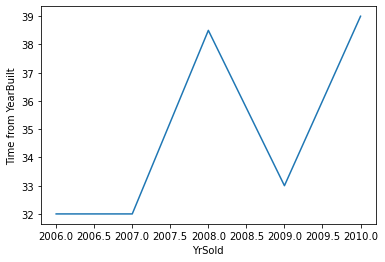

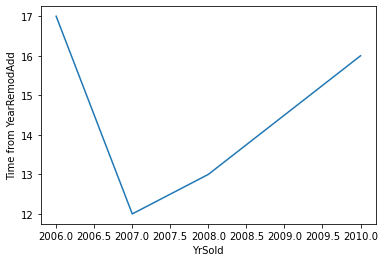

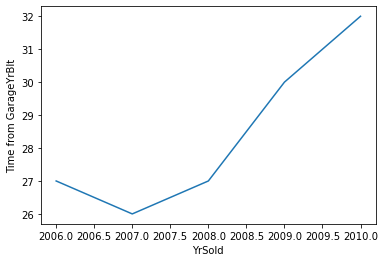

In [34]:
for var in year_vars:
    if(var != 'YrSold'):
        analyse_yearSold_vrs_timeEvents(data, var, 'YrSold')

In [35]:
def analyse_yearSold_vrs_target(df, var, varRef, Yvar):
    df = df.copy()
    df[var] = df[varRef] - df[var]
    df.groupby(var)[Yvar].median().plot()
    plt.ylabel('Time from ' + var)
    plt.show()

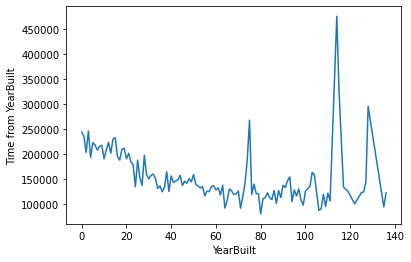

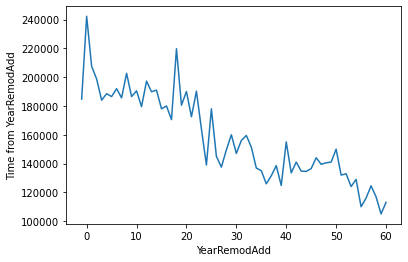

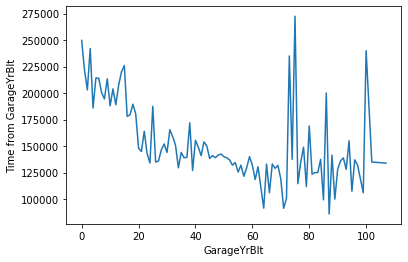

In [37]:
for var in year_vars:
    if(var != 'YrSold'):
        analyse_yearSold_vrs_target(data, var, 'YrSold', 'SalePrice')

## 2.5 Variables Discretas

In [42]:
len(data['LotFrontage'].unique()) < 20

False

In [43]:
discrete_vars = [var for var in num_vars if((len(data[var].unique()) < 20) and (var not in year_vars))]
discrete_vars

['OverallQual',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'PoolArea',
 'MoSold']

In [44]:
print("Cantidad de Variables Discretas: ", len(discrete_vars))

Cantidad de Variables Discretas:  13


In [45]:
data[discrete_vars].head()

,OverallQual,OverallCond,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,PoolArea,MoSold
0,7,5,1,0,2,1,3,1,8,0,2,0,2
1,6,8,0,1,2,0,3,1,6,1,2,0,5
2,7,5,1,0,2,1,3,1,6,1,2,0,9
3,7,5,1,0,1,0,3,1,7,1,3,0,2
4,8,5,1,0,2,1,4,1,9,1,3,0,12


In [46]:
import seaborn as sns

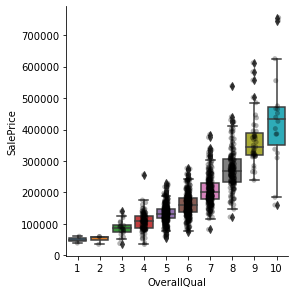

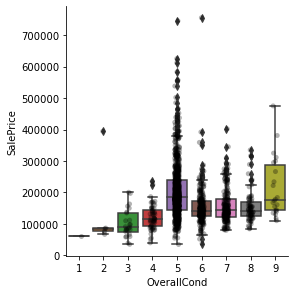

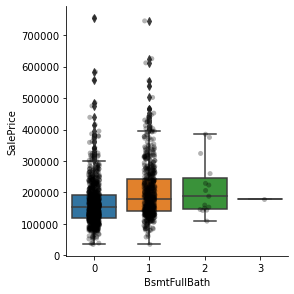

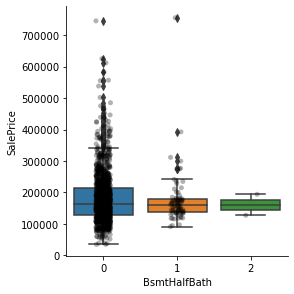

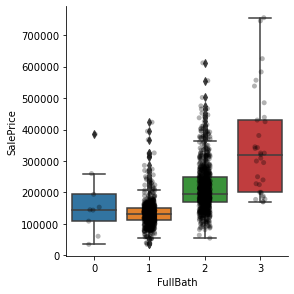

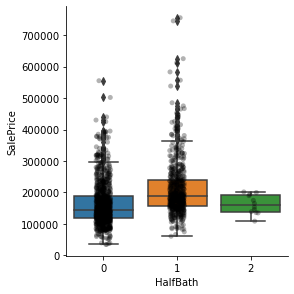

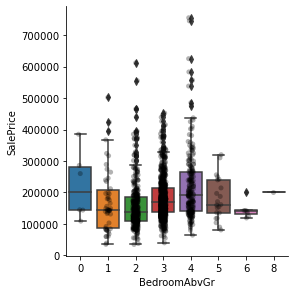

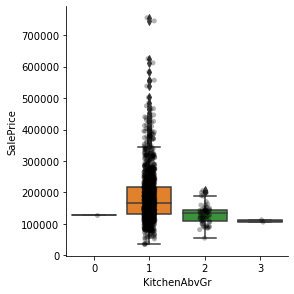

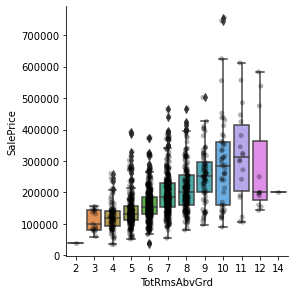

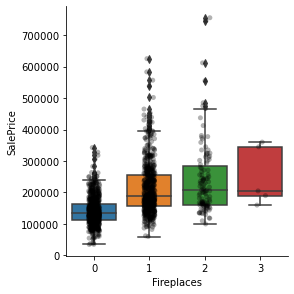

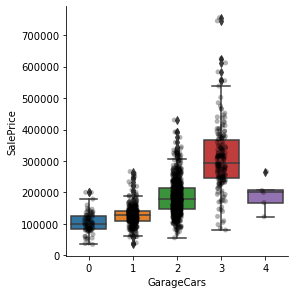

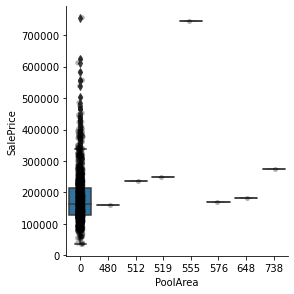

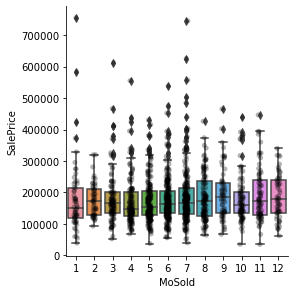

In [48]:
for var in discrete_vars:
    sns.catplot(x=var, y = 'SalePrice', data=data, kind="box", height=4)
    sns.stripplot(x=var, y='SalePrice', data=data, jitter=0.1, alpha=0.3,color='k')
    plt.show()

## 2.6 Variables Continuas

In [50]:
cont_vars = [var for var in num_vars if var not in discrete_vars + year_vars]

In [51]:
print("Variables Numericas Continuas: ", len(cont_vars))

Variables Numericas Continuas:  19


In [52]:
data[cont_vars].head()

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal,SalePrice
0,65.0,8450,196.0,706,0,150,856,856,854,0,1710,548,0,61,0,0,0,0,208500
1,80.0,9600,0.0,978,0,284,1262,1262,0,0,1262,460,298,0,0,0,0,0,181500
2,68.0,11250,162.0,486,0,434,920,920,866,0,1786,608,0,42,0,0,0,0,223500
3,60.0,9550,0.0,216,0,540,756,961,756,0,1717,642,0,35,272,0,0,0,140000
4,84.0,14260,350.0,655,0,490,1145,1145,1053,0,2198,836,192,84,0,0,0,0,250000


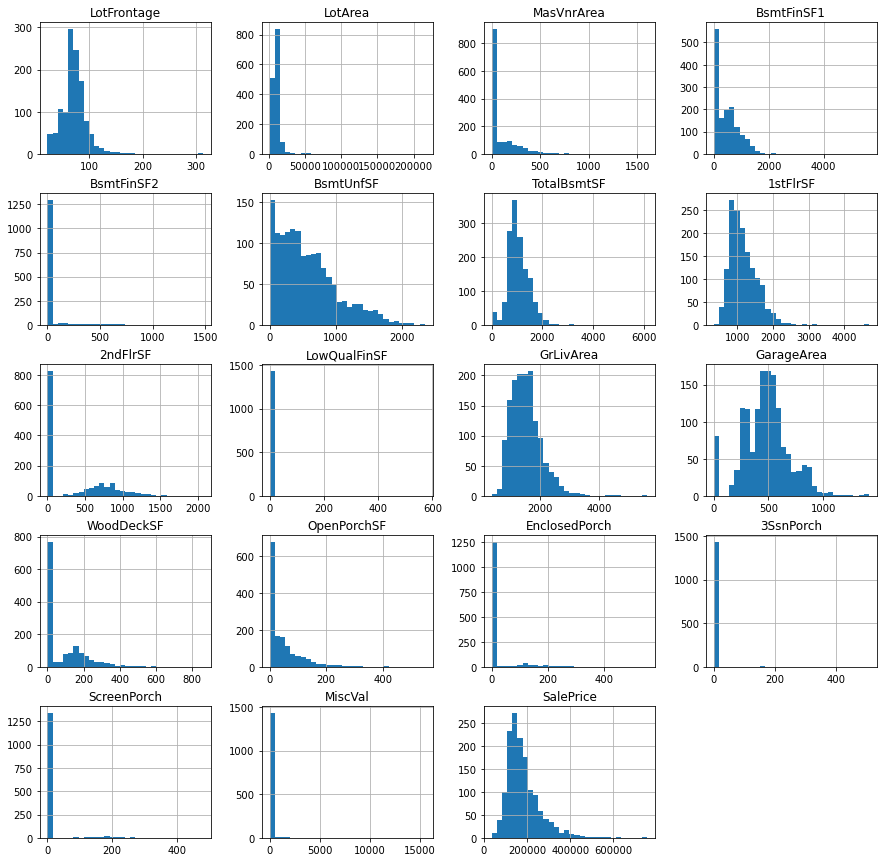

In [53]:
data[cont_vars].hist(bins=30, figsize=(15, 15))
plt.show()

In [54]:
sesgadas = ['ScreenPorch', 'MiscVal', 'EnclosedPorch', '3SsnPorch', 'LowQualFinSF', 'BsmtFinSF2']

In [56]:
cont_vars = [var for var in cont_vars if var not in sesgadas]

In [57]:
cont_vars

['LotFrontage',
 'LotArea',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'GrLivArea',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'SalePrice']

#### Transformación de Yeo-Johnson

In [96]:
import scipy.stats as stats

In [97]:
temp_yj = data.copy()

In [98]:
for var in cont_vars:
    temp_yj[var], param = stats.yeojohnson(data[var])

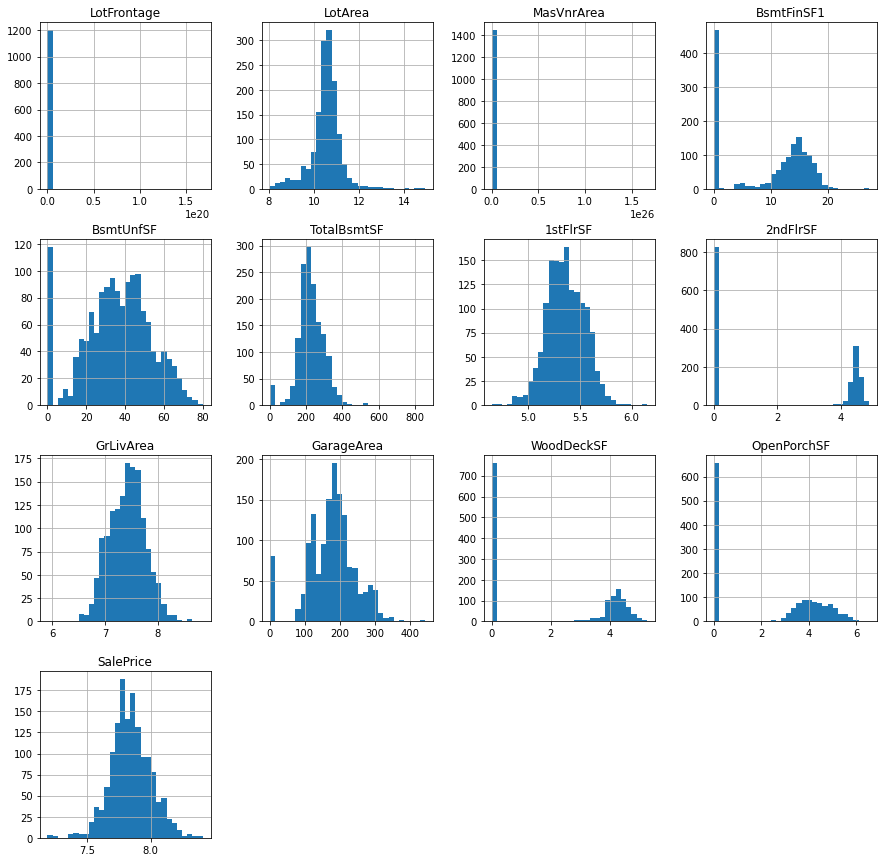

In [99]:
temp_yj[cont_vars].hist(bins=30, figsize=(15, 15))
plt.show()

In [102]:
len(cont_vars)

13

In [85]:
cont_specials = ['LotFrontage', 'MasVnrArea', '2ndFlrSF', 'WoodDeckSF', 'OpenPorchSF']

In [103]:
temp = data.copy()

for var in cont_vars:
    temp[var] = np.log(data[var] + 1)

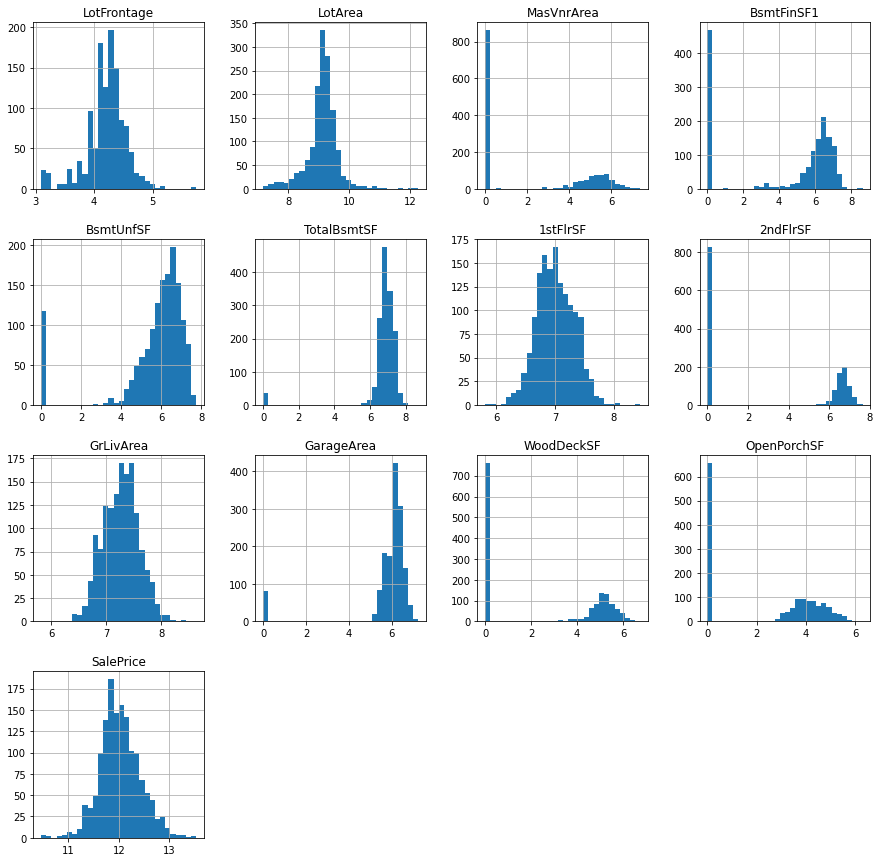

In [104]:
temp[cont_vars].hist(bins=30, figsize=(15,15))
plt.show()

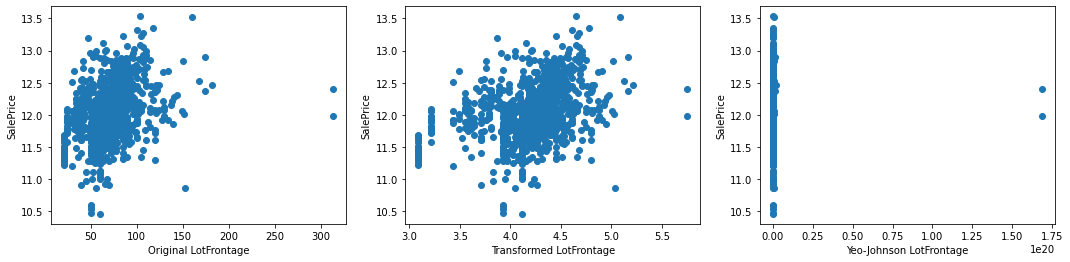

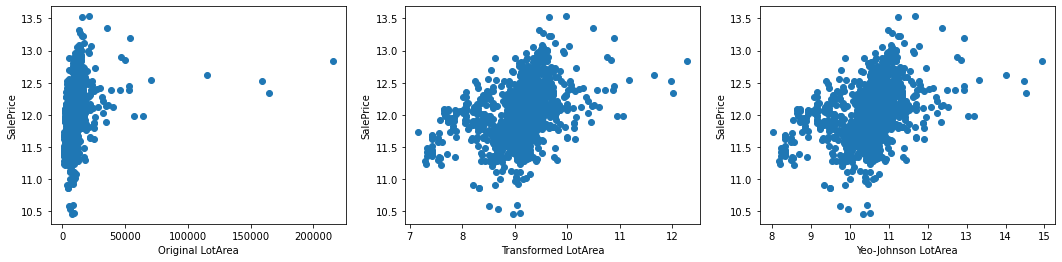

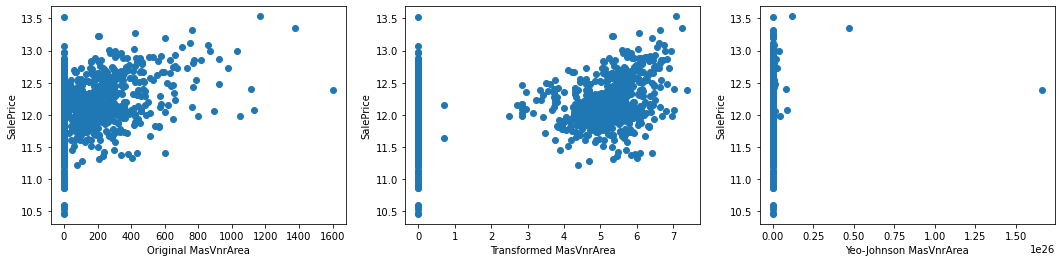

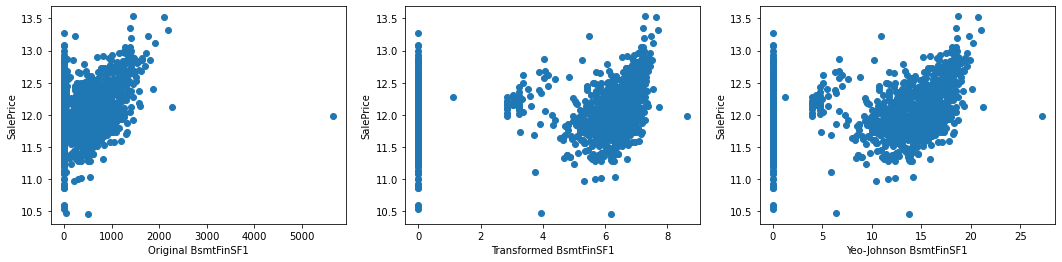

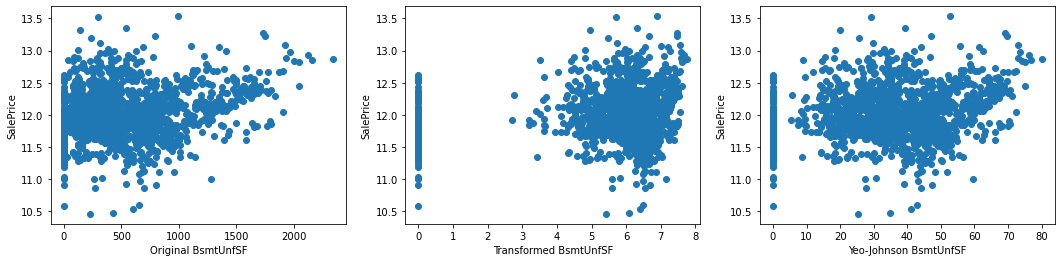

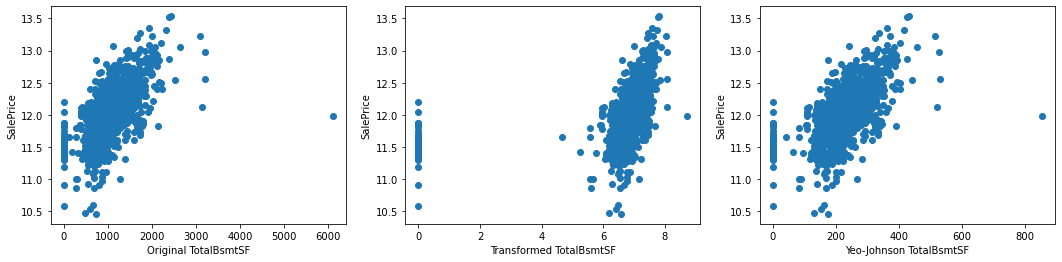

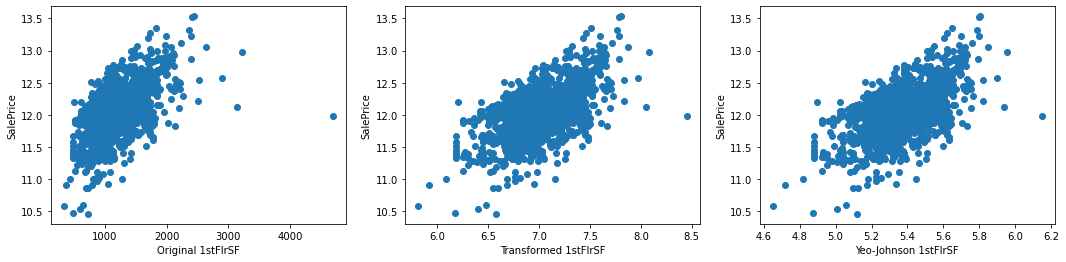

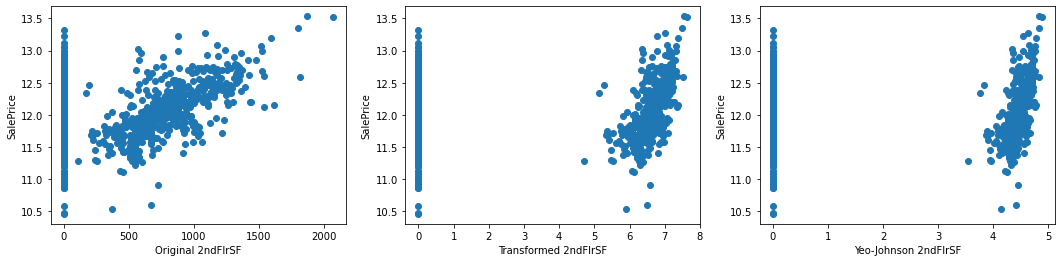

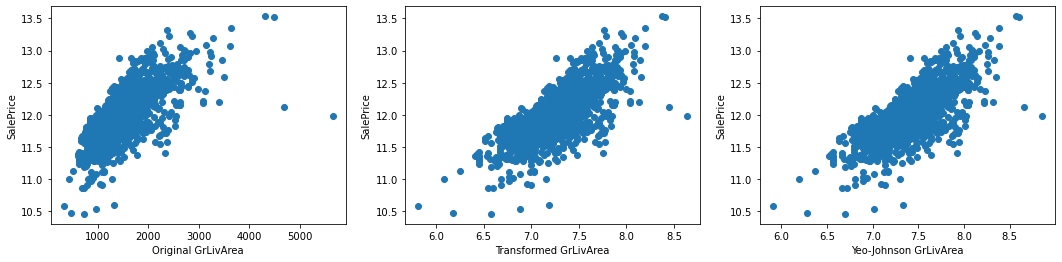

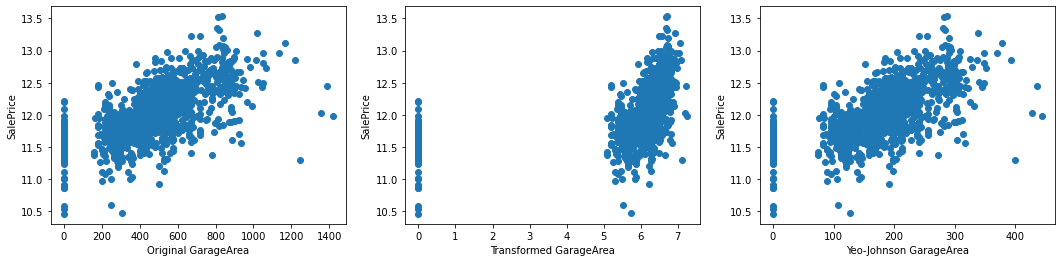

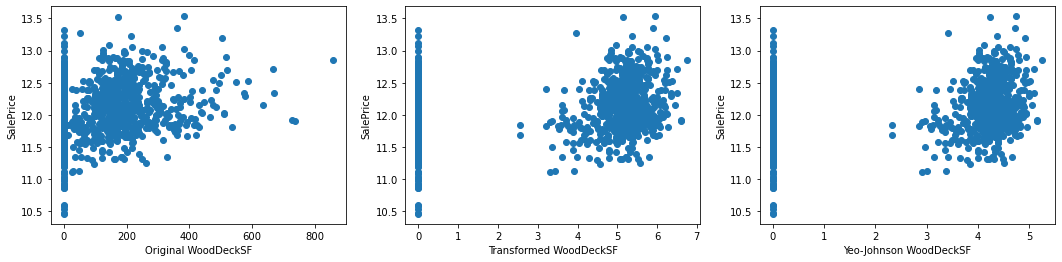

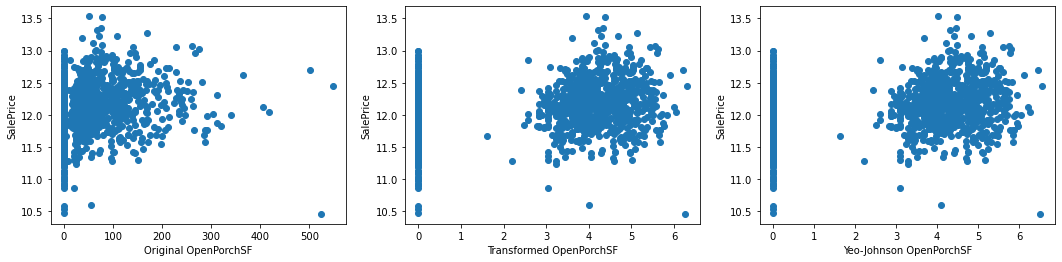

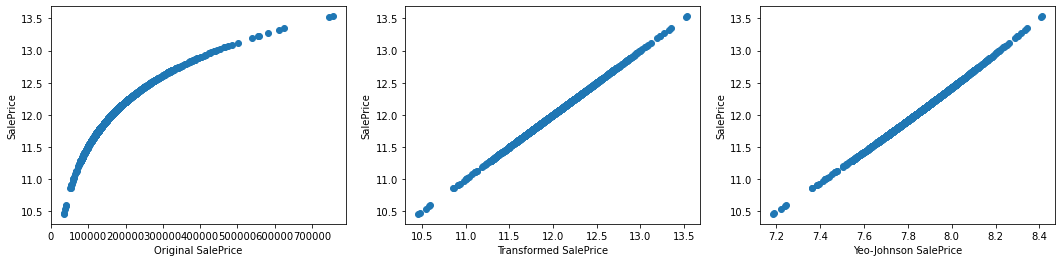

In [107]:
for var in cont_vars:
    plt.figure(figsize=(18, 4))
    
    plt.subplot(1, 3, 1)
    plt.scatter(data[var], np.log(data['SalePrice']))
    plt.ylabel("SalePrice")
    plt.xlabel("Original " + var)
    
    plt.subplot(1, 3, 2)
    plt.scatter(temp[var], np.log(data['SalePrice']))
    plt.ylabel("SalePrice")
    plt.xlabel("Transformed " + var)
    
    plt.subplot(1, 3, 3)
    plt.scatter(temp_yj[var], np.log(data['SalePrice']))
    plt.ylabel("SalePrice")
    plt.xlabel("Yeo-Johnson " + var)

    plt.show()

### 2.6.1 Variables con Sesgo

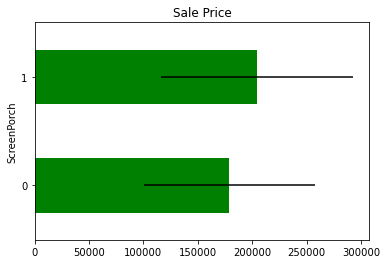

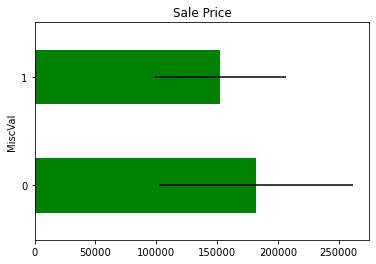

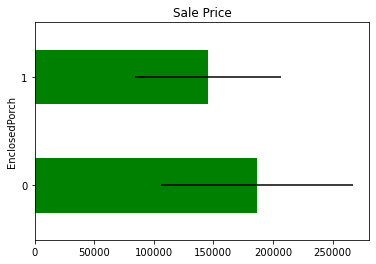

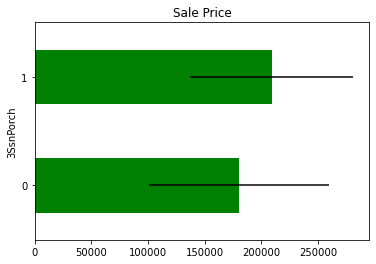

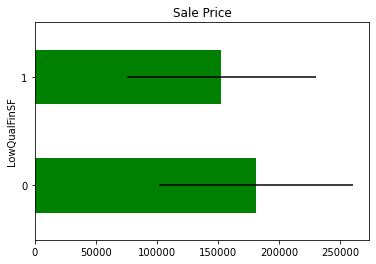

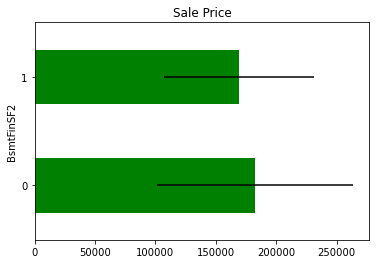

In [95]:
for var in sesgadas:
    temp = data.copy()
    
    temp[var] = np.where(data[var] == 0, 0, 1)
    
    temp = temp.groupby(var)['SalePrice'].agg(['mean', 'std'])
    
    temp.plot(kind='barh', y="mean", legend=False, xerr="std", title = "Sale Price", color="green")
    plt.show()

## 2.7 Variables Categóricas

In [108]:
len(cat_vars)

45

In [109]:
data[cat_vars].head()

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition,MSSubClass
0,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,60
1,20,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,20
2,60,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,60
3,70,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml,70
4,60,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal,60


<AxesSubplot:>

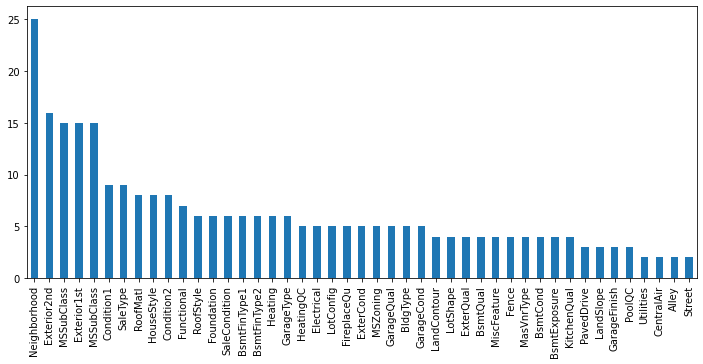

In [115]:
data[cat_vars].nunique().sort_values(ascending=False).plot.bar(figsize=(12,5))

In [118]:
np.unique(data['ExterQual'])

array(['Ex', 'Fa', 'Gd', 'TA'], dtype=object)

In [119]:
np.unique(data['ExterCond'])

array(['Ex', 'Fa', 'Gd', 'Po', 'TA'], dtype=object)

In [120]:
np.unique(data['HeatingQC'])

array(['Ex', 'Fa', 'Gd', 'Po', 'TA'], dtype=object)

In [123]:
np.unique(data['KitchenQual'])

array(['Ex', 'Fa', 'Gd', 'TA'], dtype=object)

In [ ]:
np.unique(data['FireplaceQu'])

In [134]:
data = pd.read_csv('train.csv')

In [135]:
quality_mapping = {'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5, 'Missing':0, 'NA':0, 'NaN':0}

In [136]:
qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 
            'FireplaceQu', 'GarageQual', 'GarageCond']

In [137]:
for var in qual_vars:
    data[var] = data[var].map(quality_mapping)

In [138]:
data[qual_vars].head()

,ExterQual,ExterCond,BsmtQual,BsmtCond,HeatingQC,KitchenQual,FireplaceQu,GarageQual,GarageCond
0,4,3,4.0,3.0,5,4,NaN,3.0,3.0
1,3,3,4.0,3.0,5,3,3.0,3.0,3.0
2,4,3,4.0,3.0,5,4,3.0,3.0,3.0
3,3,3,3.0,4.0,4,4,4.0,3.0,3.0
4,4,3,4.0,3.0,5,4,3.0,3.0,3.0


In [141]:
data['BsmtExposure'].unique()

array(['No', 'Gd', 'Mn', 'Av', nan], dtype=object)

In [142]:
exposure_mapping = {'No':1, 'Mn':2, 'Av':3, 'Gd':4, 'Missing':0, 'NA':0, 'NaN':0}

In [143]:
data['BsmtExposure'] = data['BsmtExposure'].map(exposure_mapping) 

In [144]:
garage_mapping = {'Unf':1, 'RFn':2, 'Fin':3, 'Missing':0, 'NA':0}

In [145]:
data['GarageFinish'] = data['GarageFinish'].map(garage_mapping) 

In [146]:
finish_mapping = {'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ':4, 'ALQ':5, 'GLQ': 6, 'Missing':0, 'NA':0}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    data[var] = data[var].map(finish_mapping)


In [152]:
fence_mapping = {'MnWw':1, 'GdWo':2, 'MnPrv':3, 'GdPrv':4, 'Missing':0, 'NA':0}

data['Fence'] = data['Fence'].map(fence_mapping)


In [150]:
qual_vars = qual_vars + finish_vars + ['BsmtExposure', 'GarageFinish', 'Fence']

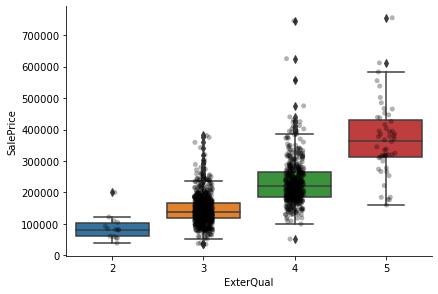

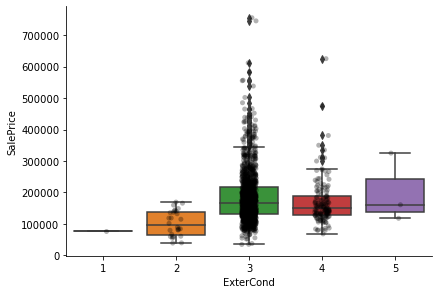

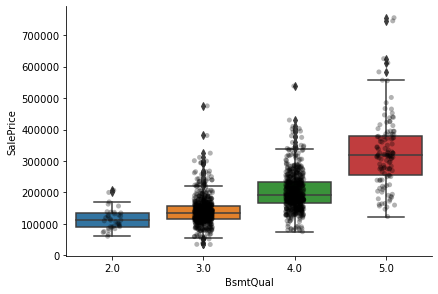

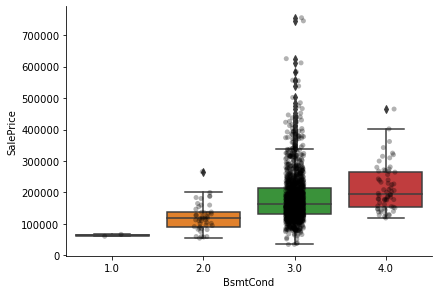

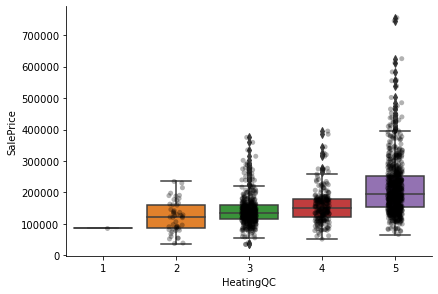

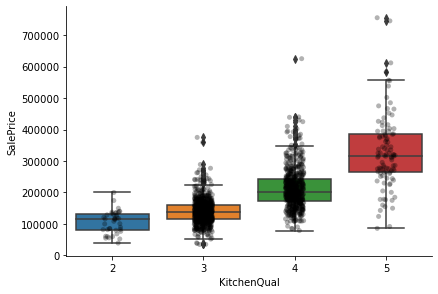

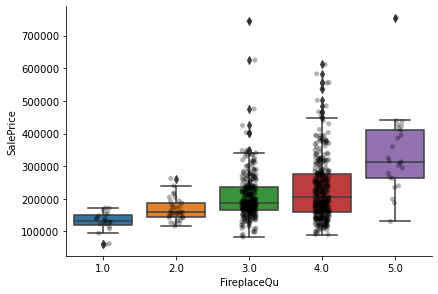

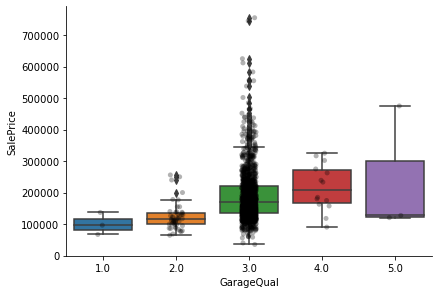

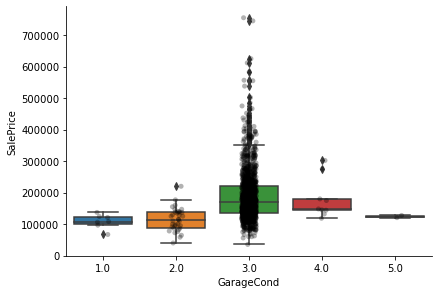

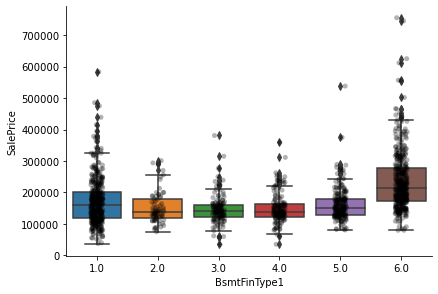

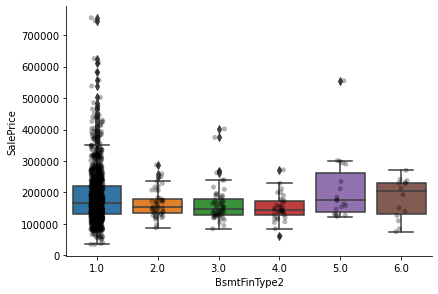

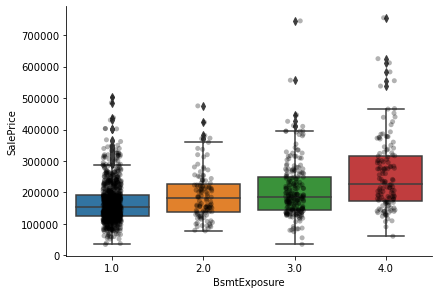

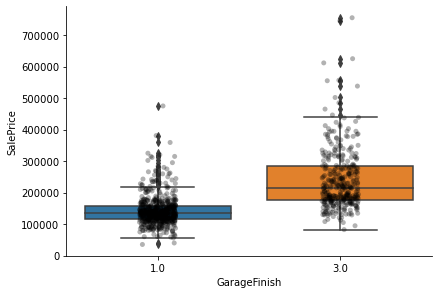

ValueError: min() arg is an empty sequence

In [153]:
for var in qual_vars:
    sns.catplot(x=var, y = 'SalePrice', data=data, kind="box", height=4, aspect=1.5)
    sns.stripplot(x=var, y='SalePrice', data=data, jitter=0.1, alpha=0.3,color='k')
    plt.show()

In [156]:
otras = [var for var in cat_vars if var not in qual_vars]

In [157]:
len(otras)

31

## 2.7 Rare Labels:

In [154]:
def analyse_rare_labels(df, var, rare_perc):
    temp = df.groupby(var)['SalePrice'].count()/len(df)
    
    return temp[temp < rare_perc]

In [ ]:
for var in otras:
    print(analyse_rare_labels(data, var, 0.01))
    print()

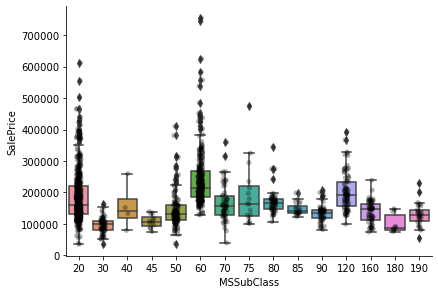

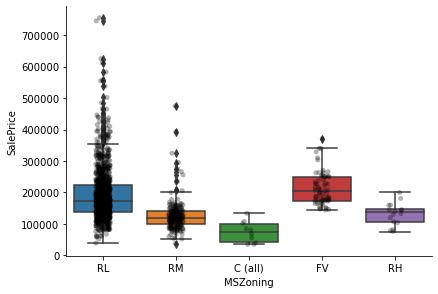

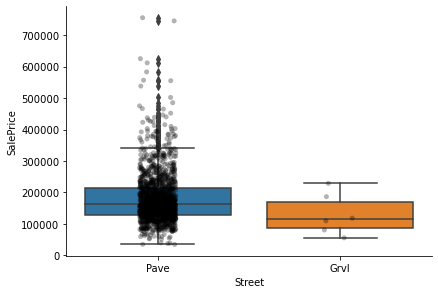

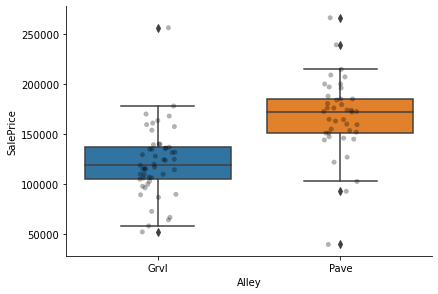

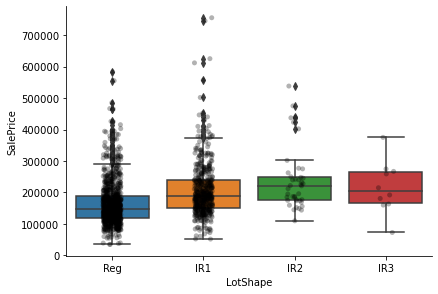

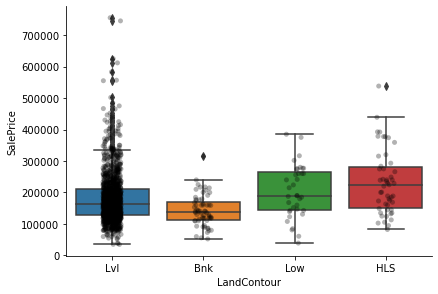

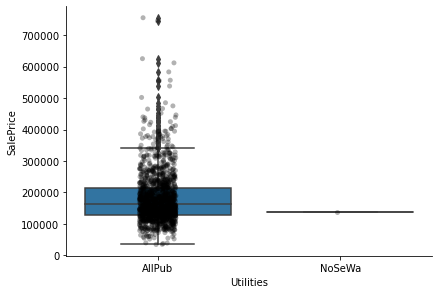

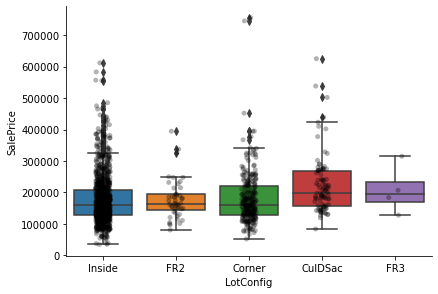

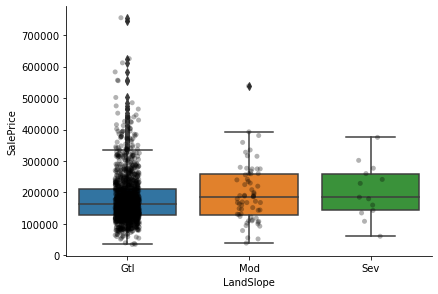

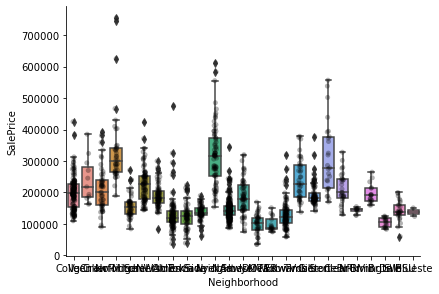

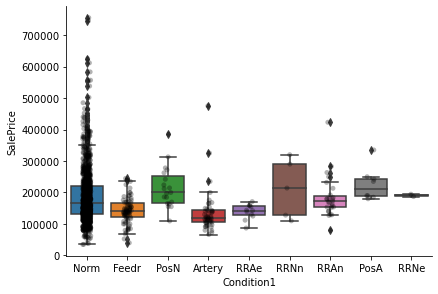

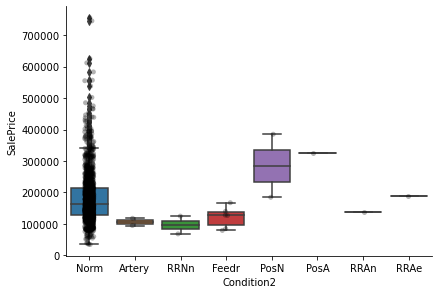

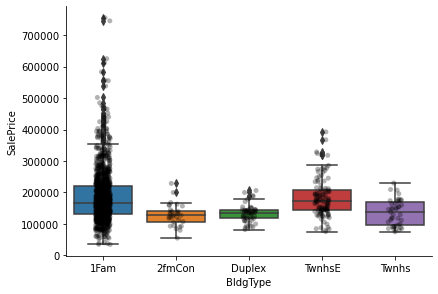

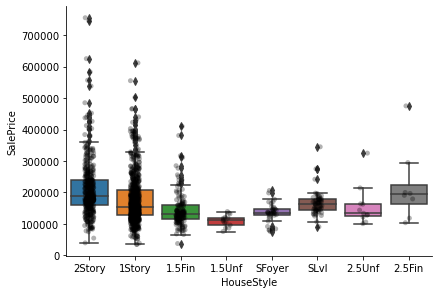

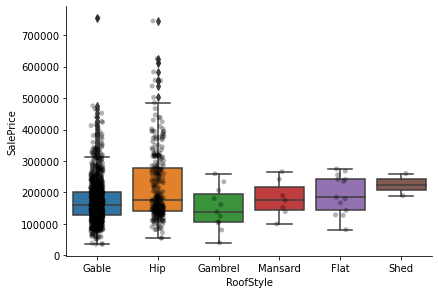

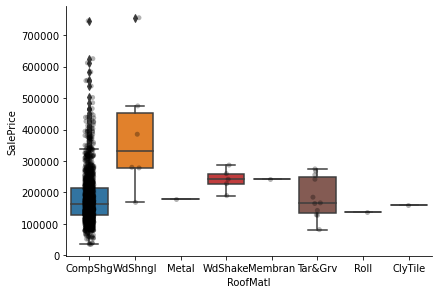

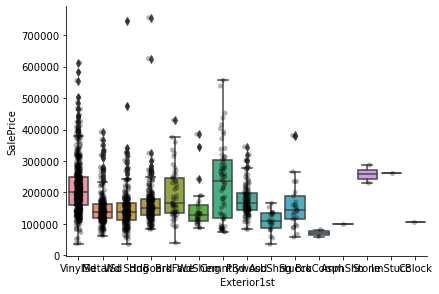

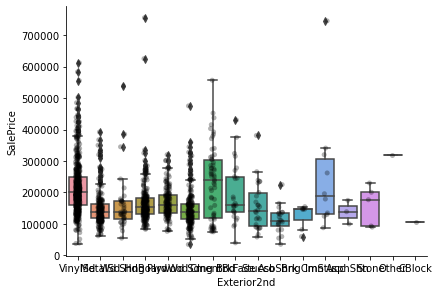

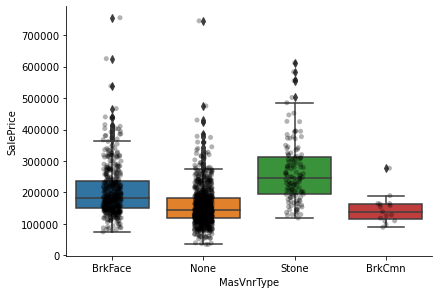

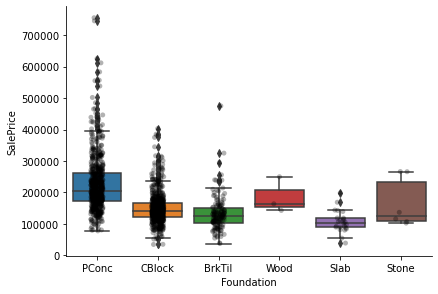

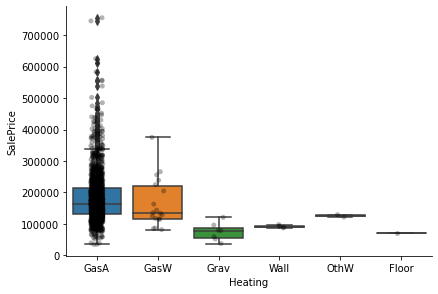

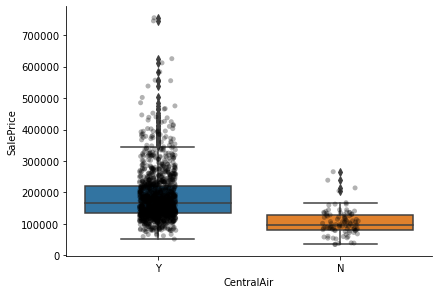

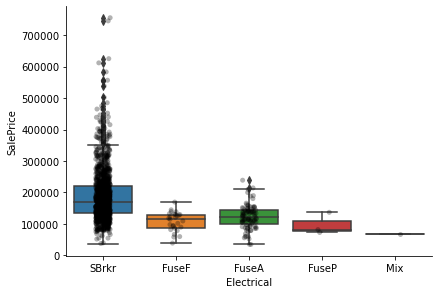

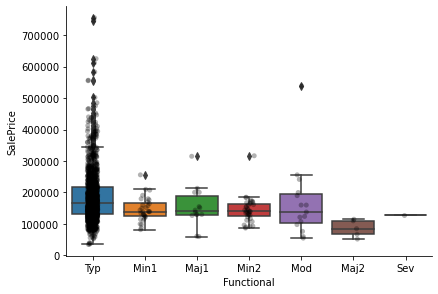

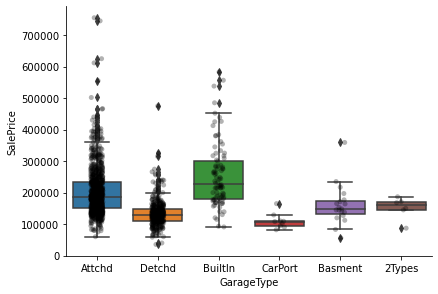

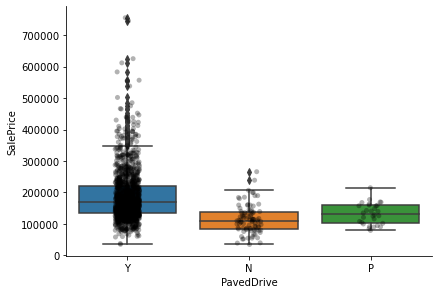

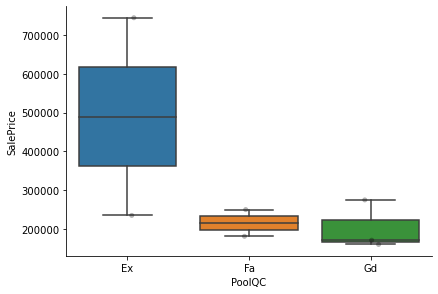

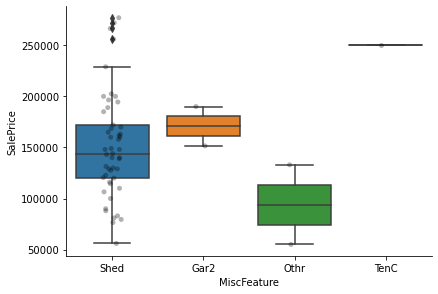

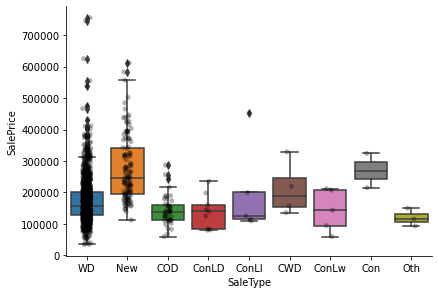

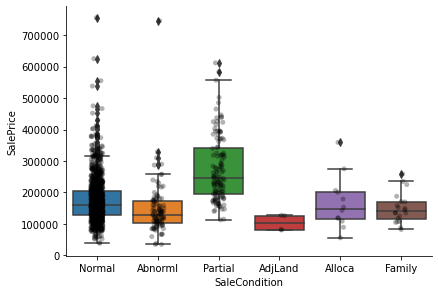

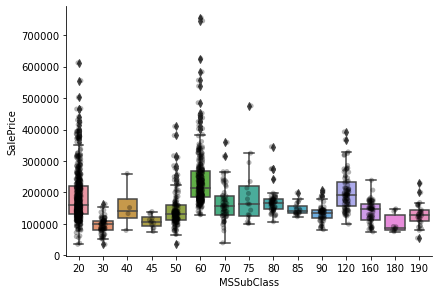

In [159]:
for var in otras:
    sns.catplot(x=var, y = 'SalePrice', data=data, kind="box", height=4, aspect=1.5)
    sns.stripplot(x=var, y='SalePrice', data=data, jitter=0.1, alpha=0.3,color='k')
    plt.show()